In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Modelling import MiningInstance, MiningLocation, EtheriumParams, estimate_profit

In [7]:
df_etherium_prices = pd.read_csv('data/ETH-USD.csv')
df_etherium_prices = df_etherium_prices[['Date', 'Adj Close']]
df_etherium_prices.rename(columns={'Adj Close': 'Price'}, inplace=True)
mask = ('2017-11-01' <= df_etherium_prices['Date']) & (df_etherium_prices['Date'] < '2018-12-01')
df_etherium_prices = df_etherium_prices.loc[mask, :].reset_index(drop=True)

In [8]:
hashrates = pd.read_csv('data/network_hashrate.csv', sep=';')

df = df_etherium_prices.merge(hashrates, on='Date')

df['Date'] = ['2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05',
              '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11']
df.rename(columns={'Date': 'Month'}, inplace=True)

In [9]:
# mining_instance = MiningInstance(name='AMD Radeon Vega', hashrate=45, power=150)
radeon_vega = MiningInstance(name='AMD Radeon Vega', hashrate=37.5, power=200)
amd_rx_580 = MiningInstance(name='AMD RX 580', hashrate=25, power=175)
asic = MiningInstance(name='ASIC', hashrate=180, power=800)
etherium_params = EtheriumParams(block_reward=3, block_time=15, network_hashrate=166*10**6, etherium_price=110)
mining_location = MiningLocation(0.1, 'Somethere on the Earth')

In [10]:
mining_instances_results = {}

for mining_instance in [radeon_vega, amd_rx_580, asic]:
    mining_instance_name = mining_instance.name
    profit_results_list = []

    for n_row in range(df.shape[0]):
        month = df.loc[n_row, 'Month']
        etherium_price = df.loc[n_row, 'Price']
        network_hashrate = df.loc[n_row, 'network_hashrate']

        etherium_params.etherium_price = etherium_price
        etherium_params.network_hashrate = network_hashrate * 10 ** 6

        value_from_mining, cost_for_electricity, profit = estimate_profit(mining_instance, mining_location, etherium_params)
        profit_result = {
            'Month': month,
            'value_from_mining': value_from_mining,
            'cost_for_electricity': cost_for_electricity,
            'profit_per_second': profit,
            'profit_per_month': profit * 60 * 60 * 24 * 30,
        }
        profit_results_list.append(profit_result)

    df_mining_instance = pd.DataFrame(profit_results_list)
    mining_instances_results[mining_instance_name] = df_mining_instance

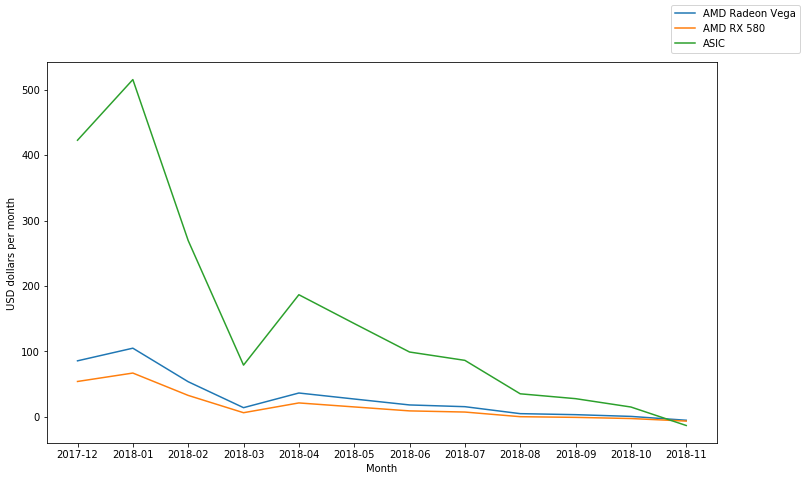

In [12]:
plt.close()
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

for mining_instances_name, mining_instances_result in mining_instances_results.items():
    months = mining_instances_result['Month'].values
    profit_per_month = mining_instances_result['profit_per_month']
    ax.plot(months, profit_per_month, label=mining_instances_name)

ax.set_xlabel('Month')
ax.set_ylabel('USD dollars per month')
fig.legend()
# fig.tight_layout()
plt.savefig('pic/profit.png')